In [1]:
"""Topic: Exploring and visualizing NFL statistics in pandas)
Web scraping data from Pro-Football-Reference for analysis
"""

# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../helper_functions')

from bs4 import BeautifulSoup
import requests, re
import pandas as pd
import numpy as np

from stat_functions import all_position_stats, all_rb_defense_headers
from get_df import fantasy_points, get_running_back_df, all_individual_stats

import matplotlib.pyplot as plt
import matplotlib.pylab as plb 
%matplotlib inline

import patsy
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline

from yellowbrick.features import Rank2D
from yellowbrick.regressor import ResidualsPlot, PredictionError

import statsmodels.formula.api as smf
import statsmodels.api as sm


In [2]:
# df_all_running_backs_2019 = all_position_stats('2019','rushing', 37)
# df_all_running_backs_2019.columns = all_rb_defense_headers('2019','rushing')

# df_all_running_backs_2019[['Att','Yds','TD','Y/A','Y/G']] = df_all_running_backs_2019[['Att','Yds','TD','Y/A','Y/G']].apply(pd.to_numeric)
# df_all_running_backs_2019 = df_all_running_backs_2019[(df_all_running_backs_2019.Pos != 'QB')]
# df_all_running_backs_2019.to_pickle("../pickled/df_all_running_backs_2019.pkl")
df_all_running_backs_2019 = pd.read_pickle("../pickled/df_all_running_backs_2019.pkl")
df_all_running_backs_2019


Link                  Player   Tm  \
Derrick Henry         /players/H/HenrDe00.htm         Derrick Henry *  TEN   
Ezekiel Elliott       /players/E/ElliEz00.htm        Ezekiel Elliott*  DAL   
Nick Chubb            /players/C/ChubNi00.htm             Nick Chubb*  CLE   
Christian McCaffrey   /players/M/McCaCh01.htm  Christian McCaffrey *+  CAR   
Chris Carson          /players/C/CarsCh00.htm            Chris Carson  SEA   
Joe Mixon             /players/M/MixoJo00.htm               Joe Mixon  CIN   
Leonard Fournette     /players/F/FourLe00.htm      Leonard Fournette   JAX   
Dalvin Cook           /players/C/CookDa01.htm            Dalvin Cook*  MIN   
Marlon Mack           /players/M/MackMa00.htm             Marlon Mack  IND   
Sony Michel           /players/M/MichSo00.htm             Sony Michel  NWE   
Le'Veon Bell          /players/B/BellLe00.htm            Le'Veon Bell  NYJ   
Carlos Hyde           /players/H/HydeCa00.htm             Carlos Hyde  HOU   
Josh Jacobs           /players/J/JacoJo01.htm             Josh Jacobs  OAK   
David Montgomery      /players/M/MontDa01.htm        David Montgomery  CHI   
Aaron Jones           /players/J/JoneAa00.htm             Aaron Jones  GNB   
Phillip Lindsay       /players/L/LindPh00.htm         Phillip Lindsay  DEN   
Todd Gurley           /players/G/GurlTo01.htm             Todd Gurley  LAR   
Saquon Barkley        /players/B/BarkSa00.htm          Saquon Barkley  NYG   
Adrian Peterson       /players/P/PeteAd01.htm         Adrian Peterson  WAS   
Mark Ingram           /players/I/IngrMa01.htm            Mark Ingram*  BAL   
Devonta Freeman       /players/F/FreeDe00.htm        Devonta Freeman   ATL   
Miles Sanders         /players/S/SandMi01.htm          Miles Sanders   PHI   
Ronald Jones II       /players/J/JoneRo01.htm         Ronald Jones II  TAM   
Alvin Kamara          /players/K/KamaAl00.htm           Alvin Kamara*  NOR   
Kenyan Drake          /players/D/DrakKe00.htm            Kenyan Drake  2TM   
Frank Gore            /players/G/GoreFr00.htm              Frank Gore  BUF   
Melvin Gordon         /players/G/GordMe00.htm           Melvin Gordon  LAC   
Peyton Barber         /players/B/BarbPe01.htm           Peyton Barber  TAM   
Devin Singletary      /players/S/SingDe00.htm        Devin Singletary  BUF   
Latavius Murray       /players/M/MurrLa00.htm         Latavius Murray  NOR   
Tevin Coleman         /players/C/ColeTe01.htm           Tevin Coleman  SFO   
Raheem Mostert        /players/M/MostRa00.htm          Raheem Mostert  SFO   
Gus Edwards           /players/E/EdwaGu00.htm            Gus Edwards   BAL   
Austin Ekeler         /players/E/EkelAu00.htm           Austin Ekeler  LAC   
Royce Freeman         /players/F/FreeRo00.htm           Royce Freeman  DEN   
Matt Breida           /players/B/BreiMa00.htm             Matt Breida  SFO   

                     Age Pos   G  GS  Att   Yds  TD  1D Lng  Y/A    Y/G Fmb  
Derrick Henry         25  RB  15  15  303  1540  16  73  74  5.1  102.7   5  
Ezekiel Elliott       24  RB  16  16  301  1357  12  78  33  4.5   84.8   3  
Nick Chubb            24  RB  16  16  298  1494   8  62  88  5.0   93.4   3  
Christian McCaffrey   23  RB  16  16  287  1387  15  57  84  4.8   86.7   1  
Chris Carson          25  RB  15  15  278  1230   7  75  59  4.4   82.0   7  
Joe Mixon             23  RB  16  15  278  1137   5  56  41  4.1   71.1   0  
Leonard Fournette     24  RB  15  15  265  1152   3  55  81  4.3   76.8   1  
Dalvin Cook           24  RB  14  14  250  1135  13  60  75  4.5   81.1   4  
Marlon Mack           23  RB  14  12  247  1091   8  67  63  4.4   77.9   0  
Sony Michel           24  RB  16  14  247   912   7  55  26  3.7   57.0   2  
Le'Veon Bell          27  RB  15  15  245   789   3  36  19  3.2   52.6   1  
Carlos Hyde           29  RB  16  14  245  1070   6  55  58  4.4   66.9   4  
Josh Jacobs           21  RB  13  13  242  1150   7  53  51  4.8   88.5   1  
David Montgomery      22  rb  16   8  242   889   6  50  55  3

In [3]:
all_running_backs_2019 = all_individual_stats(get_running_back_df, df_all_running_backs_2019, '2019')
all_running_backs_2019.to_pickle("../pickled/all_running_backs_2019.pkl")

all_running_backs_2019 = pd.read_pickle("../pickled/all_running_backs_2019.pkl")
all_running_backs_2019

index            Name  Carries  Rush_Yards  Yards_per_Carry  Rush_TD  \
0        0  Derrick Henry      19.0        84.0             4.42      1.0   
1        1  Derrick Henry      15.0        82.0             5.47      1.0   
2        2  Derrick Henry      17.0        44.0             2.59      1.0   
3        3  Derrick Henry      27.0       100.0             3.70      0.0   
4        4  Derrick Henry      20.0        78.0             3.90      1.0   
..     ...             ...      ...         ...              ...      ...   
499      7     Matt Breida     15.0        78.0             5.20      0.0   
500      8     Matt Breida     10.0        18.0             1.80      0.0   
501      9     Matt Breida      6.0        54.0             9.00      0.0   
502     10     Matt Breida      4.0        11.0             2.75      0.0   
503     11     Matt Breida      NaN         NaN              NaN      NaN   

     Targets  Receptions  Receiving_Yards   Y/R  Receiving_TD  Y/Tgt  \
0        2.0         1.0             75.0  75.0           1.0   37.5   
1        3.0         2.0             12.0   6.0           0.0    4.0   
2        2.0         1.0              2.0   2.0           0.0    1.0   
3        1.0         1.0              8.0   8.0           0.0    8.0   
4        0.0         0.0              0.0   NaN           0.0    NaN   
..       ...         ...              ...   ...           ...    ...   
499      2.0         2.0             14.0   7.0           0.0    7.0   
500      2.0         2.0              7.0   3.5           0.0    3.5   
501      1.0         1.0              4.0   4.0           0.0    4.0   
502      2.0         2.0              6.0   3.0           0.0    3.0   
503      NaN         NaN              NaN   NaN           NaN    NaN   

     Total_TDs  Pts  Fumbles  
0          2.0   12      0.0  
1          1.0    6      1.0  
2          1.0    6      0.0  
3          0.0    0      1.0  
4          1.0    6      0.0  
..         ...  ...      ...  
499        0.0    0      0.0  
500        0.0    0      0.0  
501        0.0    0      0.0  
502        0.0    0      2.0  
503        0.0    0      NaN  

[504 rows x 15 columns]

In [4]:
# all_running_backs_fantasy_2019 = all_individual_stats(fantasy_points, df_all_running_backs_2019, '2019')
# all_running_backs_fantasy_2019.to_pickle("../pickled/all_running_backs_fantasy_2019.pkl")

all_running_backs_fantasy_2019 = pd.read_pickle("../pickled/all_running_backs_fantasy_2019.pkl")
all_running_backs_fantasy_2019

index            Name  Fantasy_Points
0        1  Derrick Henry             15.4
1        2  Derrick Henry             10.6
2        3  Derrick Henry             10.8
3        4  Derrick Henry             13.8
4        5  Derrick Henry              3.3
..     ...             ...             ...
499      8     Matt Breida             2.5
500      9     Matt Breida             5.8
501     10     Matt Breida            -0.3
502     11     Matt Breida             NaN
503     12     Matt Breida             1.6

[504 rows x 3 columns]

In [5]:
# df_rushing_fantasy_2019 = all_running_backs_2019.iloc[:,1:2]

# df_rushing_fantasy_2019['Fantasy_Points'] = all_running_backs_fantasy_2019.iloc[:,-1:]

# df_rushing_fantasy_2019 = pd.concat([df_rushing_fantasy_2019, all_running_backs_2019.iloc[:,2:15]],axis=1)

# df_rushing_fantasy_2019 = df_rushing_fantasy_2019.fillna(0)

# df_rushing_fantasy_2019 = df_rushing_fantasy_2019.groupby('Name').expanding().mean().reset_index()

# df_rushing_fantasy_2019 = df_rushing_fantasy_2019.sort_values('level_1').reset_index()

# df_rushing_fantasy_2019 = df_rushing_fantasy_2019.drop(['index','level_1'],axis=1)

# df_rushing_fantasy_2019 = df_rushing_fantasy_2019.drop(['Fumbles','Pts','Total_TDs','Yards_per_Carry',
# 'Y/R','Y/Tgt','Receiving_TD'], axis=1)

# df_rushing_fantasy_2019.to_pickle("../pickled/df_rushing_fantasy_2019.pkl")

df_rushing_fantasy_2019 = pd.read_pickle("../pickled/df_rushing_fantasy_2019.pkl")

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.iloc[:,1:]

df_rushing_fantasy_2019

Fantasy_Points    Carries  Rush_Yards   Rush_TD   Targets  Receptions  \
0         15.400000  19.000000   84.000000  1.000000  2.000000    1.000000   
1         13.000000  17.000000   83.000000  1.000000  2.500000    1.500000   
2         12.266667  17.000000   70.000000  1.000000  2.333333    1.333333   
3         12.650000  19.500000   77.500000  0.750000  2.000000    1.250000   
4         10.780000  19.600000   77.600000  0.800000  1.600000    1.000000   
..              ...        ...         ...       ...       ...         ...   
499        9.187500  12.375000   65.500000  0.125000  2.000000    1.750000   
500        8.811111  12.111111   60.222222  0.111111  2.000000    1.777778   
501        7.900000  11.500000   59.600000  0.100000  1.900000    1.700000   
502        7.181818  10.818182   55.181818  0.090909  1.909091    1.727273   
503        6.716667   9.916667   50.583333  0.083333  1.750000    1.583333   

     Receiving_Yards  
0          75.000000  
1          43.500000  
2          29.666667  
3          24.250000  
4          19.400000  
..               ...  
499        12.875000  
500        12.222222  
501        11.400000  
502        10.909091  
503        10.000000  

[504 rows x 7 columns]

In [6]:
df_rushing_fantasy_2019.corr()

Fantasy_Points   Carries  Rush_Yards   Rush_TD   Targets  \
Fantasy_Points         1.000000  0.593449    0.616424  0.576088  0.388918   
Carries                0.593449  1.000000    0.819619  0.509684  0.183719   
Rush_Yards             0.616424  0.819619    1.000000  0.545283  0.170754   
Rush_TD                0.576088  0.509684    0.545283  1.000000  0.060208   
Targets                0.388918  0.183719    0.170754  0.060208  1.000000   
Receptions             0.384233  0.180461    0.176188  0.083008  0.979874   
Receiving_Yards        0.432657  0.157481    0.189327  0.177001  0.835921   

                 Receptions  Receiving_Yards  
Fantasy_Points     0.384233         0.432657  
Carries            0.180461         0.157481  
Rush_Yards         0.176188         0.189327  
Rush_TD            0.083008         0.177001  
Targets            0.979874         0.835921  
Receptions         1.000000         0.873912  
Receiving_Yards    0.873912         1.000000

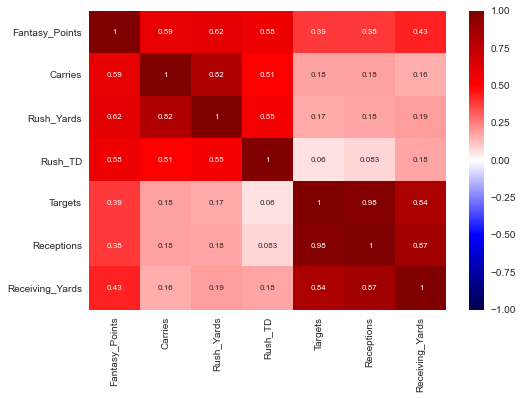

In [7]:
# example of a better corr matrix
# do this for all running backs, wide receivers, and quarterbacks
features_map = sns.heatmap(df_rushing_fantasy_2019.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, annot_kws={"fontsize":8})
fig = features_map.get_figure()
fig.savefig("features_map.png") 

# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

<AxesSubplot:title={'center':'Pearson Ranking of 7 Features'}>

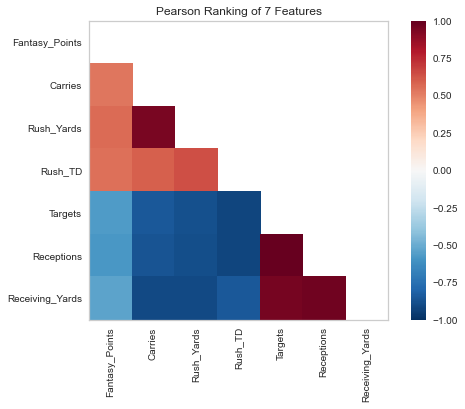

In [8]:
visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(df_rushing_fantasy_2019.corr())
visualizer.show(outpath="pcoords.png")

<Figure size 1440x540 with 0 Axes>

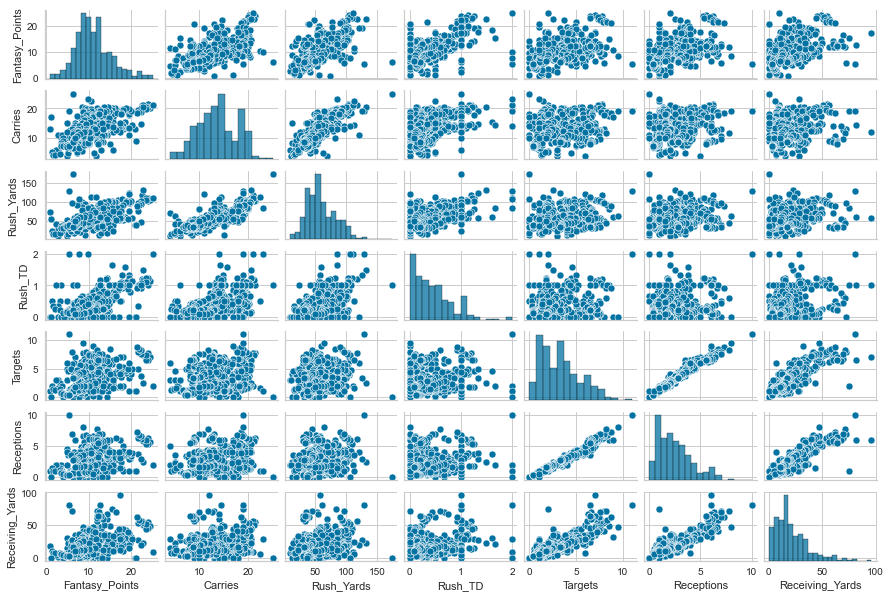

In [9]:
# do this for all running backs, wide receivers, and quarterbacks
plt.figure(figsize = [20,7.5])

sns.pairplot(df_rushing_fantasy_2019, height=1.2, aspect=1.5);

#### Cross-Validation For Model Selection

Demonstrates two typical workflows for using validation data to select models. It also demonstrates the use of some utility methods like generating **polynomial features**, converting **categorical features to "dummy variable"** binary columns, and **scaling features** when applying regularization.

**Contents Below**

> 1. Simple preprocessing and dummy variables
> 2. Basic validation method: Train/validation/test
> 3. Rigorous validation method: Cross-validation/test
> 4. Making CV less manual via scikit-learn

## 1. Preprocessing and Dummy Variables

## 2. Simple Validation Method: Train / Validation / Test

Break data into 3 portions: 60% for training, 20% for validation (used to select the model), 20% for final testing evaluation.

In [9]:
X, y = df_rushing_fantasy_2019.drop('Fantasy_Points',axis=1), df_rushing_fantasy_2019['Fantasy_Points']

# # hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=20) #why does the random state change results?
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

Model Setup: **when using regularization, we must standardize** the data so that all features are on the same scale (we subtract the mean of each column and divide by the standard deviation, giving us features with mean 0 and std 1). Since this scaling is part of our model, we need to scale using the training set feature distributions and apply the same scaling to validation and test without refitting the scaler. 

Also, we need to get **polynomial features** for the poly model

In [11]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

# Higher alpha = strong regularization strength 
lm_las = Lasso(alpha=0.01320088400831418)
lm_reg = Ridge(alpha=5.415871378079471)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

<AxesSubplot:>

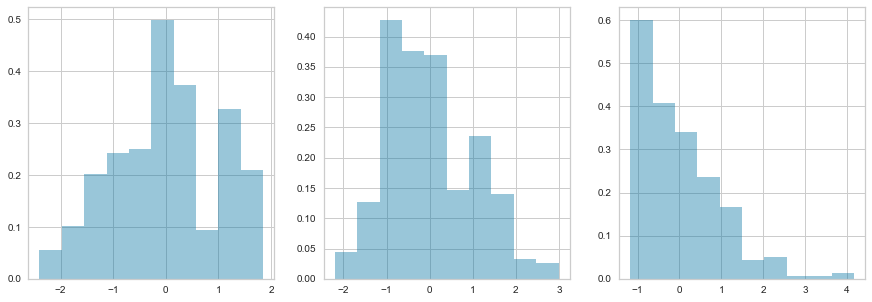

In [12]:
# Plot histograms of a few transformed variables
# Note that they seem to have means of 0 and stddevs of 1
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.distplot(X_train_scaled[:, 0], label='feature 1', ax=axes[0], kde=False, bins=10, norm_hist=True)
sns.distplot(X_train_scaled[:, 1], label='feature 2', ax=axes[1], kde=False, bins=10, norm_hist=True)
sns.distplot(X_train_scaled[:, 2], label='feature 3', ax=axes[2], kde=False, bins=10, norm_hist=True)


In [13]:
lm.fit(X_train_scaled, y_train)
print(f'Linear Regression Train R^2: {lm.score(X_train_scaled, y_train):.3f}')
print(f'Linear Regression Val R^2: {lm.score(X_val_scaled, y_val):.3f}')
print(f'Linear Regression Test R^2: {lm.score(X_test_scaled, y_test):.3f}\n')

lm_las.fit(X_train_scaled, y_train)

print(f'Lasso Regression Train R^2: {lm_las.score(X_train_scaled, y_train):.3f}')
print(f'Lasso Regression Val Scaled R^2: {lm_las.score(X_val_scaled, y_val):.3f}')
print(f'Lasso Regression Test R^2: {lm_las.score(X_test_scaled, y_test):.3f}\n')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression Train R^2: {lm_reg.score(X_train_scaled, y_train):.3f}')
print(f'Ridge Regression Val Scaled R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')
print(f'Ridge Regression Test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}\n')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression Train R^2: {lm_poly.score(X_train_poly, y_train):.3f}')
print(f'Degree 2 polynomial regression Val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
print(f'Degree 2 polynomial regression Test R^2: {lm_poly.score(X_test_poly, y_test):.3f}')

Linear Regression Train R^2: 0.585
Linear Regression Val R^2: 0.394
Linear Regression Test R^2: 0.672

Lasso Regression Train R^2: 0.584
Lasso Regression Val Scaled R^2: 0.413
Lasso Regression Test R^2: 0.672

Ridge Regression Train R^2: 0.580
Ridge Regression Val Scaled R^2: 0.426
Ridge Regression Test R^2: 0.670

Degree 2 polynomial regression Train R^2: 0.718
Degree 2 polynomial regression Val R^2: 0.132
Degree 2 polynomial regression Test R^2: 0.543


Negative R^2 equals severe overfitting! 

So having run this validation step, we see that the evidence points to Lasso regression being the best model. So our validation process lets us **select** that choice of model, and as our final step we retrain it on the entire chunk of train/val data and see how it does on test data:  

## 3. Rigorous Validation Method: Cross-Validation / Test

Break data into 2 portions: 80% for a cross-validated training process, and 20% for final testing evaluation. 

Remember that the idea of CV is to make efficient use of the data available to us (using 80% instead of 60% above), while also performing multiple validation checks. For k-fold CV, we come up with k train/validation splits of the whole chunk of data, in such a way that **each observation is in the validation set exactly 1 time**. 

For simplicity we'll focus on linear regression and ridge regression (we also can feel pretty comfortable throwing out the full degree 2 polynomial regression based on the poor results above!) As we loop through our CV folds, we will train and validate both models and collect the results to compare at the end. Note that we scale the training features within the CV loop.

In [14]:
#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [15]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_train_r2s, cv_lm_val_r2s, cv_lm_las_r2s, cv_lm_reg_r2s, rmses = [], [], [], [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm.fit(X_train, y_train)
    cv_lm_train_r2s.append(lm.score(X_train, y_train))
    cv_lm_val_r2s.append(lm.score(X_val, y_val))

    
    lm_rmse = mean_squared_error(y_val, lm.predict(X_val), squared=False)

    rmses.append(lm_rmse)

    # setup for ridge and lasso 
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    #lass with feature scaling 
    lm_las.fit(X_train_scaled, y_train)
    cv_lm_las_r2s.append(lm_las.score(X_val_scaled, y_val))

    #ridge with feature scaling
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_val_r2s)
print('Lasso scores: ', cv_lm_las_r2s, '\n')
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Lasso mean cv r^2: {np.mean(cv_lm_las_r2s):.3f} +- {np.std(cv_lm_las_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

print(f'Simple mean cv r^2 (TRAIN): {np.mean(cv_lm_train_r2s):.3f} +- {np.std(cv_lm_train_r2s):.3f}')
print(f'Simple mean cv r^2 (VAL): {np.mean(cv_lm_val_r2s):.3f} +- {np.std(cv_lm_val_r2s):.3f}')
print(f'Simple mean RMSE: {np.mean(rmses):.3f} +- {np.std(rmses):.3f}')

Simple regression scores:  [0.4068652871612095, 0.4337668199285276, 0.21649570812112173, 0.750674522087492, 0.7355067631634615]
Lasso scores:  [0.41185664199539784, 0.4462041075358877, 0.20470743634409772, 0.7416217926384462, 0.7378517469819408] 

Ridge scores:  [0.4134982279509549, 0.45667770408927866, 0.21101794159791498, 0.7395437215752552, 0.7382562356886755] 

Lasso mean cv r^2: 0.508 +- 0.206
Ridge mean cv r^2: 0.512 +- 0.203
Simple mean cv r^2 (TRAIN): 0.556 +- 0.047
Simple mean cv r^2 (VAL): 0.509 +- 0.206
Simple mean RMSE: 2.886 +- 0.617


The plot thickens! Our simple validation method above pointed to simple linear regression being better than lasso and ridge, but k-fold shows the opposite. The lasso model appears to be both better on average and has less varying results.

**Since k-fold is more reliable than a single validation set, we select the lasso regression model**. This shows the dangers of relying on simple validation methods, especially when our sample sizes are small.

In [16]:
list(zip(df_rushing_fantasy_2019.columns[1:],lm_las.coef_))

[('Carries', 0.935332998806056),
 ('Rush_Yards', 0.8661233342496275),
 ('Rush_TD', 1.1219111436143596),
 ('Targets', 1.716146239787661),
 ('Receptions', -1.7494128411565761),
 ('Receiving_Yards', 1.2604653479110655)]

In [17]:
list(zip(df_rushing_fantasy_2019.columns[1:],lm_reg.coef_))

[('Carries', 0.9290234482284243),
 ('Rush_Yards', 0.8758400038961127),
 ('Rush_TD', 1.1137048214846983),
 ('Targets', 1.2832332184642217),
 ('Receptions', -1.2416445602509618),
 ('Receiving_Yards', 1.1733523687272576)]

**LASSO**:
* _Pro_: great for trimming features and focusing interpretation on a few key ones
* _Con_: risk of discarding features that are actually useful

**Ridge**:
* _Pro_: great for smoothly handling multicollinearity, very nice when working with sparse features 
* _Con_ (ish): will never fully discard features

As always, you have to validate to choose between the two. If the mapping from features to target truly depends on only a few key features, LASSO should outperform. If instead the target actually depends on many features (even if only a little dependent), Ridge should work better.  

## 4. Tuning Regularization Strength via Validation

Here we will attempt to find the "best" value of the regularization strength alpha for this feature and target set and the LASSO model. We'll use simple validation (single train/valid split) as our model selection method.

We will first decide on a vector of "candidate" alpha values.  Then, for each candidate value, we run the following steps:

> 1. Fit a LASSO model on the training data
> 2. Using the newly trained model, make predictions on the validation data
> 3. Run evaluation metrics on validation

Then we plot how the errors change for the different values of alpha, and see where alpha minimizes our error metric on the validation data. This value of alpha is the one we would select for our final model.

In [18]:
test_set_pred = lm_las.predict(X_test)

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

92.31147780042906

In [19]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    # pipe.fit(X_train.loc[:,selected_columns].values, y_train)
    pipe.fit(X_train, y_train)
    
    # val_set_pred = pipe.predict(X_val.loc[:,selected_columns].values)
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)

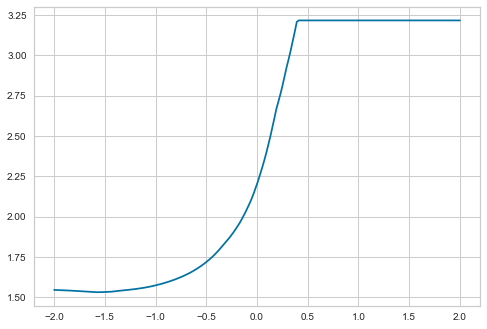

In [20]:
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)

In [21]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val)

1.5315917337135063

In [22]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

0.026430814869741057

---
**Regularization Tuning Exercise**: 

Repeat the model selection workflow above (simple validation), but using a ridge model instead of a LASSO model. Based on the evidence you gather, do you think that a ridge or LASSO model has better predictive power on this dataset?

---

In [23]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('Ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    # pipe.fit(X_train.loc[:,selected_columns].values, y_train)
    pipe.fit(X_train, y_train)
    
    # val_set_pred = pipe.predict(X_val.loc[:,selected_columns].values)
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)

In [24]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val)

1.5327226690687468

In [25]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

9.01101825166502

## LassoCV for Running Backs

In [26]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lm_las_CV = LassoCV(alphas = alphavec, cv=5)
lm_las_CV.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [27]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lm_las_CV.alpha_

0.01

In [28]:
# L = LassoCV()
# s = StandardScaler(with_mean=False)
# X_train_poly_scaled = s.fit_transform(X_train_poly)
# L.fit(X_train_poly_scaled, y_train)

# print("Training Score: ", L.score(X_train_poly_scaled, y_train), "Test Score: " , L.score(s.transform(p.transform(X_test)),y_test))

In [29]:
# R = RidgeCV()
# R.fit(X_train_poly_scaled, y_train)

# print("Training Score: ", R.score(X_train_poly_scaled, y_train), "Test Score: " , R.score(s.transform(p.transform(X_test_scaled)),y_test))

## 3. Standard-scaling Features (a must for regularization!)

One issue with Regularized Linear Regression is that the "size" of a coefficient may be more reflective of the units or scale of the associated variable than the actual power of the relationship.  For example, if a distance is measured in millimeters it will have a larger coefficient than if it is measured in miles.  For this reason, best practice is to "standardize" the variables prior to running a regularized regression.  Standardizing means subtracting off each feature column's mean and then dividing by its standard deviation so that the resulting variable has mean 0 and standard deviation 1. This ensures that the variables are penalized fairly with respect to one another.

We demonstrate how to do this below.

## Linear Regression Modeling

Text(0, 0.5, 'Actual Values')

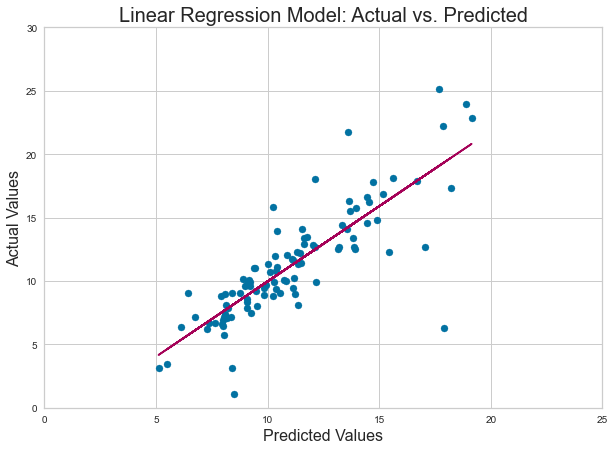

In [30]:
lm_predict = lm.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_predict, y_test)
ax = plt.gca()

z = np.polyfit(lm_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_predict, p(lm_predict), "m-")

plt.xlim(0,25)
plt.ylim(0,30)

plt.title('Linear Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

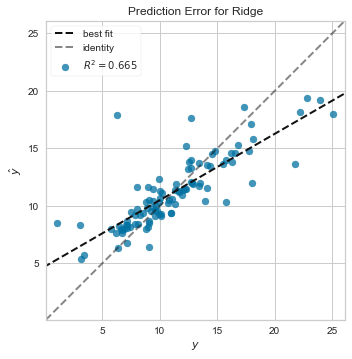

<AxesSubplot:title={'center':'Prediction Error for Ridge'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [31]:
visualizer = PredictionError(Ridge(alpha=3.181))
visualizer.fit(X_train_scaled, y_train)
visualizer.score(X_test_scaled, y_test)
visualizer.show()

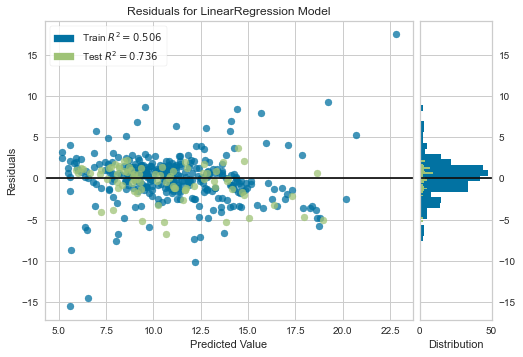

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [32]:
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train_scaled, y_train)
visualizer.score(X_val_scaled, y_val)
visualizer.show()

In [33]:
df_rushing_fantasy_2019_predicted = df_rushing_fantasy_2019
df_rushing_fantasy_2019_predicted['Tested_Fantasy_Points'] = pd.DataFrame(y_test)
df_rushing_fantasy_2019_predicted['Predicted_Fantasy_Points'] = pd.DataFrame(lm_predict)
df_rushing_fantasy_2019_predicted['Name'] = all_running_backs_2019.iloc[:,1:2]
df_rushing_fantasy_2019_predicted = df_rushing_fantasy_2019_predicted.dropna()
df_rushing_fantasy_2019_predicted


Fantasy_Points    Carries  Rush_Yards   Rush_TD   Targets  Receptions  \
2        12.266667  17.000000   70.000000  1.000000  2.333333    1.333333   
9        15.750000  18.700000   83.200000  0.800000  1.800000    1.300000   
10       16.190909  18.727273   90.090909  0.909091  1.727273    1.272727   
13       17.764286  19.357143   94.928571  0.928571  1.714286    1.285714   
14       18.000000  13.000000   53.000000  1.000000  2.000000    1.000000   
16       14.133333  18.333333   96.333333  0.666667  2.333333    1.666667   
17       14.375000  18.250000   81.000000  0.750000  3.500000    2.750000   
19       16.583333  18.833333   81.833333  0.833333  3.833333    3.000000   
29       15.800000  17.000000   75.000000  0.000000  4.000000    3.000000   
31       21.733333  19.333333   77.666667  0.333333  5.000000    3.666667   
34       18.133333  19.000000  101.166667  1.000000  4.333333    3.333333   
35       16.842857  19.142857  105.428571  0.857143  3.857143    3.000000   
47       23.925000  21.500000  102.750000  1.000000  7.750000    6.250000   
49       22.816667  21.166667  103.000000  1.166667  7.333333    5.833333   
56       22.246154  18.923077   93.846154  0.923077  8.230769    6.615385   
63       12.880000  18.800000   76.000000  0.200000  3.400000    3.000000   
72       12.685714  19.285714   85.000000  0.500000  3.285714    2.571429   
74        9.050000   8.500000   13.500000  0.000000  4.000000    2.500000   
76        8.825000  11.750000   37.250000  0.000000  3.750000    2.750000   
81       10.077778  14.555556   48.222222  0.000000  3.111111    2.333333   
84       11.350000  15.250000   53.583333  0.166667  2.916667    2.166667   
90       14.133333  14.333333   59.666667  0.000000  6.666667    4.666667   
91       15.525000  18.000000  101.000000  0.000000  5.750000    4.000000   
92       14.780000  19.000000  102.400000  0.200000  6.000000    4.000000   
94       14.571429  20.571429  102.142857  0.142857  5.428571    4.000000   

    Receiving_Yards  Tested_Fantasy_Points  Predicted_Fantasy_Points  \
2         29.666667              12.266667                 18.210159   
9         16.700000              15.750000                  7.983245   
10        16.636364              16.190909                 10.032909   
13        14.714286              17.764286                 10.239156   
14        10.000000              18.000000                 12.120077   
16        11.000000              14.133333                 11.492647   
17        15.750000              14.375000                  8.039602   
19        23.333333              16.583333                 13.336815   
29        10.000000              15.800000                  8.159318   
31        27.000000              21.733333                 10.839627   
34        21.333333              18.133333                  9.095413   
35        19.285714              16.842857                  5.111379   
47        54.500000              23.925000                 11.431790   
49        50.833333              22.816667                 11.355016   
56        55.846154              22.246154                  9.224419   
63        21.000000              12.880000                 19.139282   
72        17.571429              12.685714                  9.532927   
74         8.500000               9.050000                 11.178622   
76        13.000000               8.825000                  8.078889   
81        16.333333              10.077778                 10.329596   
84        15.833333              11.350000                 10.091183   
90        31.333333              14.133333                  9.842983   
91        28.500000              15.525000                 14.463555   
92        28.600000              14.780000                  9.080178   
94        29.000000              14.571429                  9.182650   

                    Name  
2         Derrick Henry   
9         Derrick Henry   
10        Derrick Henry   
13        Derrick He

In [37]:
df_rushing_fantasy_2019_predicted.iloc[:,-3:-1].mean()

Tested_Fantasy_Points       15.617565
Predicted_Fantasy_Points    10.703657
dtype: float64

## Ridge Regression Modeling

Text(0, 0.5, 'Actual Values')

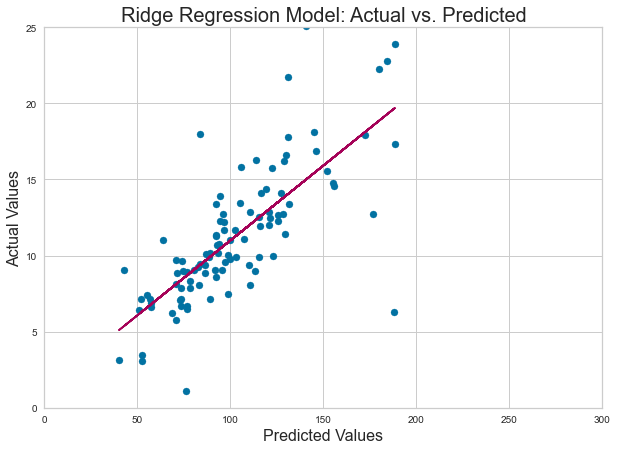

In [38]:
lm_reg_predict = lm_reg.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_reg_predict, y_test)

z = np.polyfit(lm_reg_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_reg_predict, p(lm_reg_predict), "m-")

plt.xlim(0,300)
plt.ylim(0,25)

plt.title('Ridge Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

## Lasso Regression

Text(0, 0.5, 'Actual Values')

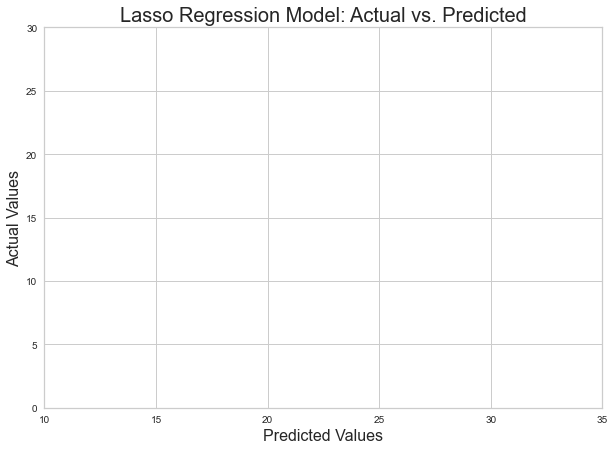

In [39]:
lm_las_predict = lm_las.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_las_predict, y_test)

z = np.polyfit(lm_las_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_las_predict, p(lm_las_predict), "m-")

plt.xlim(10,35)
plt.ylim(0,30)

plt.title('Lasso Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

In [74]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('Fantasy_Points ~ Receptions + Rush_Yards + Receiving_Yards + Rush_TD + Receiving_TD', data=df_rushing_fantasy_2019, 
return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

PatsyError: Error evaluating factor: NameError: name 'Receiving_TD' is not defined
    Fantasy_Points ~ Receptions + Rush_Yards + Receiving_Yards + Rush_TD + Receiving_TD
                                                                           ^^^^^^^^^^^^

In [41]:
# Define the model
lm1 = smf.ols('Fantasy_Points ~ Rush_Yards + Receiving_Yards + Rush_TD + Receiving_TD', data=df_rushing_fantasy_2019)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     152.7
Date:                Fri, 09 Oct 2020   Prob (F-statistic):           3.47e-85
Time:                        02:44:35   Log-Likelihood:                -1247.2
No. Observations:                 504   AIC:                             2504.
Df Residuals:                     499   BIC:                             2525.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.4878      0.379      9.198      0.000       2.743       4.233
Rush_Yards          0.0721      0.007     10.570      0.000       0.059       0.086
Receiving_Yards     0.0845      0.011      7.745      0.000       0.063       0.106
Rush_TD             3.5730      0.416      8.586      0.000       2.755       4.391
Receiving_TD        0.0260      0.916      0.028      0.977      -1.774       1.826
==============================================================================
Omnibus:                      116.268   Durbin-Watson:                   1.277
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2329.646
Skew:                          -0.406   Prob(JB):                         0.00
Kurtosis:                      13.501   Cond. No.                         484.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
# Define the model
lm2 = smf.ols('Fantasy_Points ~ Rush_Yards + Receiving_Yards + Rush_TD + Receiving_TD', data=df_rushing_fantasy_2019)

# Fit the model
fit2 = lm2.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     152.7
Date:                Fri, 09 Oct 2020   Prob (F-statistic):           3.47e-85
Time:                        02:44:35   Log-Likelihood:                -1247.2
No. Observations:                 504   AIC:                             2504.
Df Residuals:                     499   BIC:                             2525.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.4878      0.379      9.198      0.000       2.743       4.233
Rush_Yards          0.0721      0.007     10.570      0.000       0.059       0.086
Receiving_Yards     0.0845      0.011      7.745      0.000       0.063       0.106
Rush_TD             3.5730      0.416      8.586      0.000       2.755       4.391
Receiving_TD        0.0260      0.916      0.028      0.977      -1.774       1.826
==============================================================================
Omnibus:                      116.268   Durbin-Watson:                   1.277
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2329.646
Skew:                          -0.406   Prob(JB):                         0.00
Kurtosis:                      13.501   Cond. No.                         484.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# Define the model
lm3 = smf.ols('Fantasy_Points ~ Rush_Yards + Receiving_Yards + Rush_TD', data=df_rushing_fantasy_2019)

# Fit the model
fit3 = lm3.fit()

# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     204.0
Date:                Fri, 09 Oct 2020   Prob (F-statistic):           2.23e-86
Time:                        02:44:35   Log-Likelihood:                -1247.2
No. Observations:                 504   AIC:                             2502.
Df Residuals:                     500   BIC:                             2519.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.4887      0.378      9.238      0.000       2.747       4.231
Rush_Yards          0.0721      0.007     10.833      0.000       0.059       0.085
Receiving_Yards     0.0847      0.009      9.914      0.000       0.068       0.101
Rush_TD             3.5738      0.415      8.619      0.000       2.759       4.389
==============================================================================
Omnibus:                      116.427   Durbin-Watson:                   1.277
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2335.229
Skew:                          -0.408   Prob(JB):                         0.00
Kurtosis:                      13.514   Cond. No.                         225.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

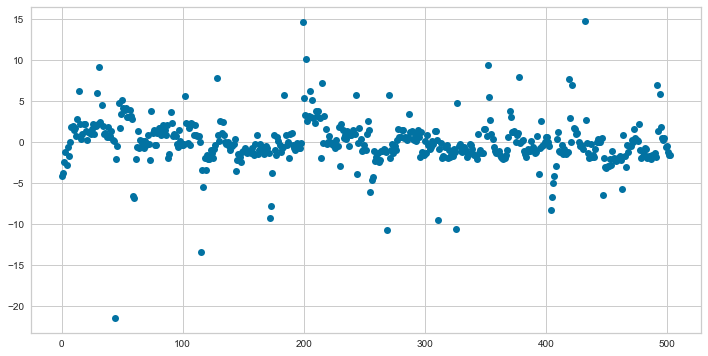

In [44]:
#Residual plot comparing actual vs. predicted values. In a good model we want our errors to be random. I'm not sure if the below looks too random. It seems to be between -5, so what does that mean? May be missing actual functional dependency underlying the data. This data may not be linear but let's keep going. 
fit1.resid.plot(style='o',figsize=(12,6))

<AxesSubplot:>

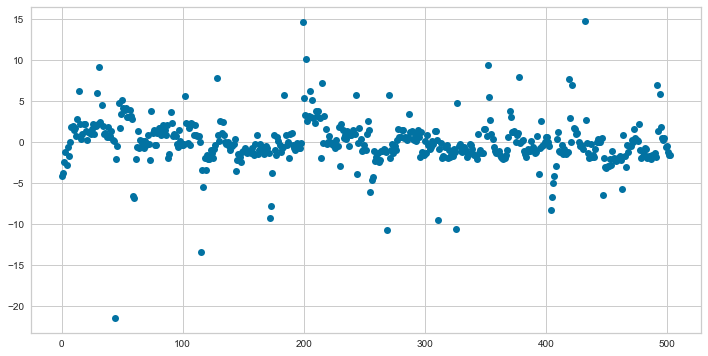

In [45]:
fit2.resid.plot(style='o',figsize=(12,6))

<AxesSubplot:>

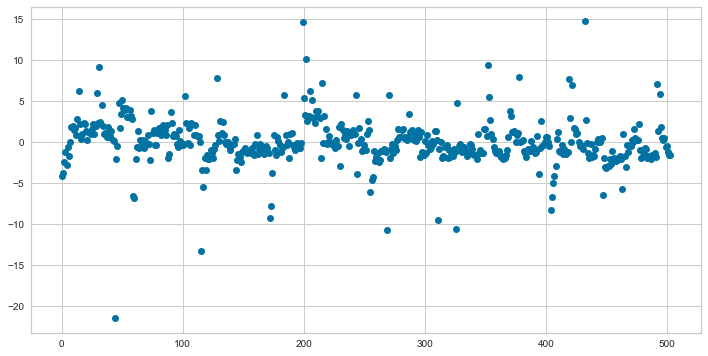

In [46]:
fit3.resid.plot(style='o',figsize=(12,6))